In [1]:
from qiskit import *

In [2]:
# Create a quantum circuit with three qubits and three classical bits

num_qubits = 3

circuit = QuantumCircuit(num_qubits, num_qubits)

# Add a Hadamard gate to the first qubit in order to transform it from the default |0> state
# to the |+> state.
circuit.h(0)

# Add CNOT gates between qubits 1 & 2, and 2 & 3. This means that there is a 50% chance that
# qubit 2 flips to state |0>, and if that occurs, qubit 3 will also flip to the same state.
circuit.cx(0,1)
circuit.cx(1,2)

# Finally, we add measurements of the three qubits and store them in the classical bits.
circuit.measure([0,1,2], [0,1,2])

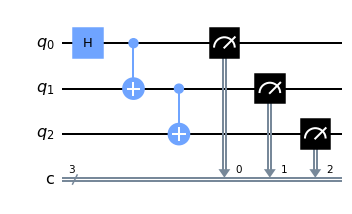

In [3]:
%matplotlib inline
circuit.draw(output = 'mpl')

In [4]:
# We simulate the execution of the circuit if it were to run on a perfect quantum computer.
# We run the simulation 1024 times and store the results in sim_result.
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend = simulator, shots = 1024).result()

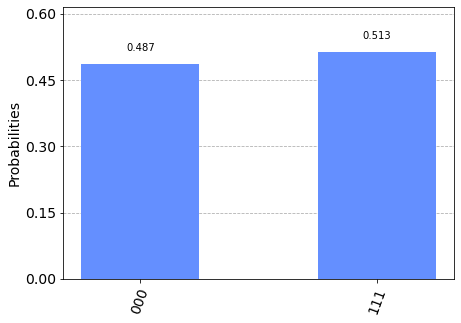

In [5]:
from qiskit.visualization import plot_histogram
plot_histogram(sim_result.get_counts(circuit))

### We expect roughly a 50-50% split between the outcomes |000> and |111> for the state of the system. This is because, after the Hadamard transformation of the 1st q-bit, there is a 50% chance that it is now in state |1> upon measurement. If that is indeed the case, then because of the CNOT gates, the other two q-bits will also change to state |1>. Otherwise, all three q-bits will be in state |0>

In [8]:
# Load my IBMQ account and get the provider of quantum computer available to me
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')

# Choose a specific quantum computer to run the circuit on
device = provider.get_backend('ibmq_quito')

ibmqfactory.load_account:WARNING:2021-10-05 20:22:44,462: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
# Run the circuit on the real quantum computer 1024 times
job = execute(circuit, backend=device, shots=1024)
print(job.job_id()) # Print the ID of the job we are running

from qiskit.tools.monitor import job_monitor
job_monitor(job) # Monitor the job to check its status, i.e., place in the queue

615ca69ba8477c55f57c4f2d
Job Status: job has successfully run


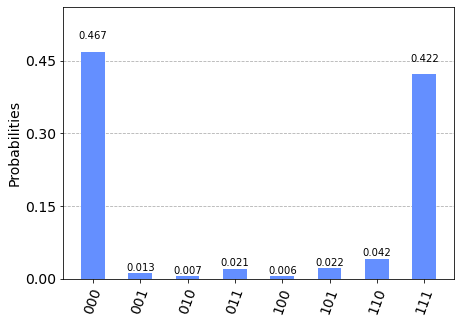

In [10]:
# Get the results from the execution of the ciruit on the real quantum computer
device_result = job.result()

# Plot the results in a histogram
plot_histogram(device_result.get_counts(circuit))

### Note that the results from the execution of the circuit on a real quantum computer contain all possible states of a 3 q-bit system. In other words, it includes the states different from |000> and |111> which are the only ones we expect theoretically. This is because there is some noise present in the real quantum system, for they are not perfect. We will now see how we can mitigate that noise.

In [12]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

8


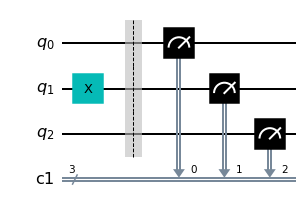

In [14]:
# Get a series of calibration circuits containing a quantum register of 3 q-bits from Ignis
# to find what the noise errors are when we run them.
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0],
                                               circlabel = 'measerrormitigationcal')
# This is the number of the circuits provided (we expect these to be 8 for 3 q-bits)
print(len(cal_circuits))

# This is an example of a circuit:
cal_circuits[2].draw(output='mpl')

In [15]:
# Run the calibration circuits on the quantum device chosen above, each 1024 times.
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0 # This makes sure the circuits are not changed upon transferring to the quantum device.
                 )
print(cal_job.job_id())
job_monitor(cal_job)

# Save the results from the execution of the job
cal_results = cal_job.result()

615cab4699d773aea1ea3fdc
Job Status: job has successfully run


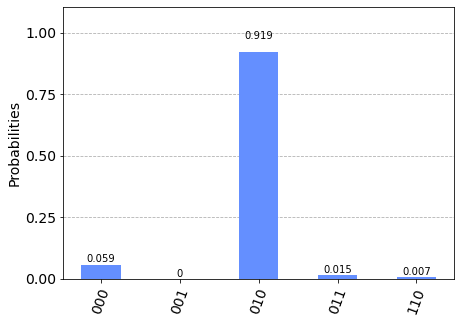

In [16]:
# Plot the results from the execution of a specific circuit onto a histogram
plot_histogram(cal_results.get_counts(cal_circuits[2]))

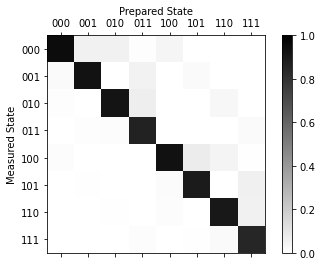

In [17]:
# Create a measurement fitter that shows how the fraction of measured states depends on
# the specific prepared state.
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

In [18]:
# Create a measurement filter based on the fitter above
meas_filter = meas_fitter.filter

In [19]:
# Get results from the execution of the initial circuit (Hadamard and CNOTs) after the filter
# is applied
mitigated_result = meas_filter.apply(device_result)

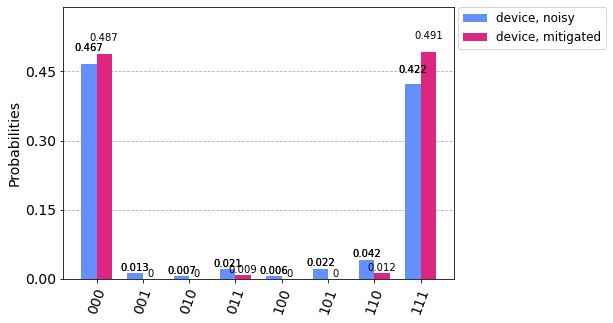

In [21]:
# Plot the original results along with the filtered ones on a single histogram to compare
# the use of this noise mitigation strategy
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

### Notice how the fraction of runs of the circuit resulting in measured states which are technically not possible is much lower after we have applied the mitigation filter.

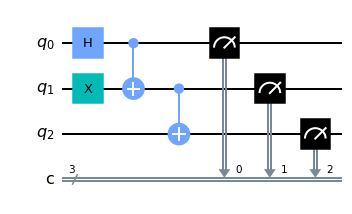

In [22]:
# If we build another circuit containing 3 q-bits, we can use the filter created above to 
# mitigate errors in that one as well.
circuit_2 = QuantumCircuit(num_qubits, num_qubits)

circuit_2.x(1)
circuit_2.h(0)
circuit_2.cx(0, 1)
circuit_2.cx(1, 2)

circuit_2.measure([0,1,2], [0,1,2])

circuit_2.draw(output='mpl')

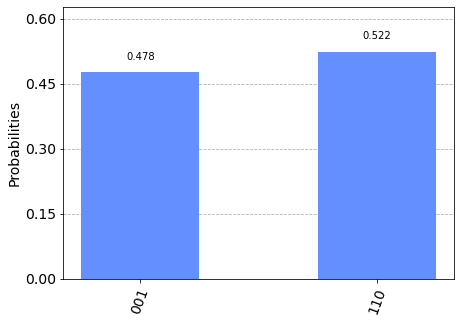

In [23]:
# Plot the results from simulating the execution of the circuit above on a perfect quantum
# computer
plot_histogram(
    execute(circuit_2, backend=simulator, shots=1024).result().get_counts(circuit_2)
)

### The only measured states available in the results are |100> and |011>, which is what we expect theoretically.

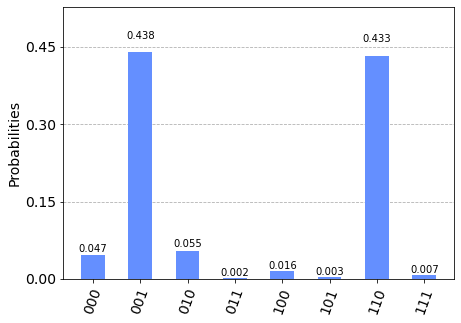

In [24]:
# Run the circuit above on a real quantum computer instead of simulating its execution
device_counts_2 = execute(circuit_2, backend=device, shots=1024).result().get_counts(circuit_2)
plot_histogram(device_counts_2)

### We see that all possible 3 q-bit states are measured, as was seen for the previous circuit. This is, as said already, due to the presence of noise in real quantum computers.

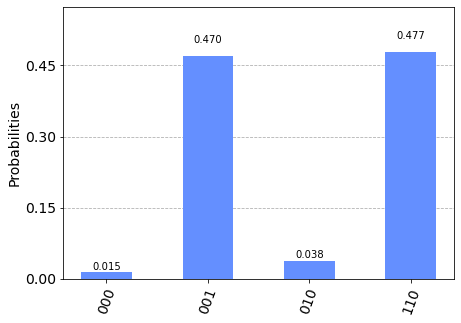

In [26]:
# We again apply the 3 q-bit filter from above to the results for this new circuit, and plot
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)
plot_histogram(device_mitigated_counts_2)

### So as we saw for the first circuit, applying the noise mitigation filter allows us the make the results from running the circuit on a real quantum computer closer to what we would see on a perfect quantum computer, at least in terms of the fraction of measured states. In fact, notice that some of the 8 possible 3 q-bits states do not appear at all in the filtered results, which is what we would expect theoretically. The awesome thing is that we can use the same 3 q-bit filter for different circuits.